In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
#from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

## Load data

In [4]:
data = pd.read_csv('MA_Features.csv', encoding= 'utf-8')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110519 entries, 0 to 110518
Data columns (total 35 columns):
Patient_ID                      110519 non-null float64
Appointment_ID                  110519 non-null int64
Patient_Gender                  110519 non-null int64
Appointment_ScheduledDate       110519 non-null object
Appointment_Date                110519 non-null object
Patient_Age                     110519 non-null int64
Patient_Neighbourhood           110519 non-null object
Patient_Scholarship             110519 non-null int64
Patient_Hypertension            110519 non-null int64
Patient_Diabetes                110519 non-null int64
Patient_Alcoholism              110519 non-null int64
Patient_Handicap                110519 non-null int64
SMS_Received                    110519 non-null int64
No_Show                         110519 non-null int64
Appointment_Scheduled_Year      110519 non-null int64
Appointment_Scheduled_Month     110519 non-null int64
Appointment_Schedule

## Model analysis functions

In [5]:
def rocPlot(modelName, y_test, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=modelName)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(modelName + ' ROC Curve')
    plt.show();
    print('AUC: ', roc_auc_score(y_test, y_pred_prob))

In [6]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
def gridSearch(model, param_grid, cv, x, y):
    grid = GridSearchCV(model, param_grid, cv= cv)
    grid.fit(x, y)
    return (grid.best_params_, grid.best_score_)

In [8]:
def parameterTuning(name, train_accuracy, train_f1, test_accuracy, test_f1, values):
    # Generate plot
    plt.title(name +': Varying parameter')
    ax = plt.gca()
    ax2 = ax.twinx()
    ax.plot(values, test_accuracy, label = 'Testing Accuracy')
    ax.plot(values, train_accuracy, label = 'Training Accuracy')
    ax2.plot(values, test_f1, label = 'Testing F1 Score', color='red')
    ax2.plot(values, train_f1, label = 'Training F1 Score', color='green')
    ax.set_xlabel('values')
    ax.set_ylabel('Accuracy')
    ax2.set_ylabel('F1 Score')
    ax.legend(loc=0)
    ax2.legend(loc=1)
    plt.show()

In [9]:
def crossValidation(model, X, y):
    cv_scores = cross_val_predict(model, X, y, cv=10)
    
    report = classification_report(cv_scores, y)
    conf_matrix = confusion_matrix(cv_scores, y)
    print(report)
    print('F1 score achieved {}'.format( f1_score(cv_scores, y, average="macro")))
    print('Accuracay score achieved {}'.format( accuracy_score(cv_scores, y)))
    plot_confusion_matrix(conf_matrix, ['Show', 'No Show'], normalize= True)

In [10]:
def modelROC(model, modelName, X_train, y_train, X_test, y_test):
    logreg.fit(X_train, y_train)
    y_pred_prob = logreg.predict_proba(X_test)[:,1]
    rocPlot(modelName, y_test, y_pred_prob)

In [11]:
def trainAndPredict(model, modelName, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    report = classification_report(predictions, y_test)
    conf_matrix = confusion_matrix(predictions, y_test)
    print(report)
    print('F1 score achieved {}'.format( f1_score(predictions, y_test, average="macro")))
    print('Accuracy score achieved {}'.format( accuracy_score(predictions, y_test)))
    plot_confusion_matrix(conf_matrix, ['Show', 'No Show'], normalize= True)
    
    
    
    y_pred_prob = model.predict_proba(X_test)[:,1]
    rocPlot(modelName, y_test, y_pred_prob)

In [12]:
def modelParameterTuning(modelName, initializer, param, X_train, y_train, X_test, y_test):
    train_accuracy = np.empty(len(param))
    test_accuracy = np.empty(len(param))
    train_f1 = np.empty(len(param))
    test_f1 = np.empty(len(param))
    
    # Loop over different values of k
    for i, k in enumerate(param):
        model = initializer(k)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_train)
        #Compute accuracy on the training set
        train_accuracy[i] = accuracy_score(y_train, y_pred)
        train_f1[i] = f1_score(y_train, y_pred, average="macro")
        
        y_pred = model.predict(X_test)
        #Compute accuracy on the testing set
        test_accuracy[i] = accuracy_score(y_test, y_pred)
        test_f1[i] = f1_score(y_test, y_pred, average="macro")
        
    parameterTuning(modelName, train_accuracy, train_f1, test_accuracy, test_f1, param)
        


In [13]:
def modelGridSearch(model, cv):
    best_param, best_score = gridSearch(model, param_grid, cv, X_train, y_train)
    
    # Print the tuned parameters and score
    print("Tuned Parameters: {}".format(best_param)) 
    print("Best score is {}".format(best_score))

In [14]:
def getAdjustedData(predictors):
    predictors = predictors + ['Patient_ID', 'No_Show']
    X = data[predictors]
    y = data.No_Show
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 121, stratify= y)

    ## Get no show per patient for training data only
    temp_1 = X_train.groupby('Patient_ID').count()
    temp_2 = X_train.groupby('Patient_ID').sum()

    no_show_per_patient = pd.DataFrame()
    no_show_per_patient['ratio'] = temp_2['No_Show'] / temp_1['No_Show']
    
    X_train['ratio'] = X_train.Patient_ID.apply(lambda x: no_show_per_patient.loc[x])
    X_train['ratio'] = X_train['ratio'].astype(np.float64)

    def adjust(row):
        patient_id = row['Patient_ID']
        p = X_train[X_train.Patient_ID == patient_id]
        if(p.empty):
            return 0
        else:
            return p['ratio'].iloc[0]
    
    
    ## Copy the values computed for the patient that already have a record
    X_test['ratio'] = X_test.apply(adjust, axis= 1)
    
    col_to_drop = ['Patient_ID', 'No_Show']
    X_test = X_test.drop(col_to_drop, axis= 1)
    X_train = X_train.drop(col_to_drop, axis= 1)
    
    return X_train, X_test, y_train, y_test
    

## Random Forest

In [34]:
def randomForestModel(p):
    clf= RandomForestClassifier(n_estimators=p)
    return clf
def randomForestAnalysis(X_train, X_test, y_train, y_test):
    print('Cross validation Analysis\n')
    clf=RandomForestClassifier()
    crossValidation(clf,X,y)
    
    print('Prediction Analysis\n')
    clf = RandomForestClassifier()
    trainAndPredict(clf, 'Random Forest', X_train, y_train, X_test, y_test)
    
    print('Parameter Analysis\n')
    n_estimators = np.linspace(10, 100, num=50,dtype=int)
    modelParameterTuning('Random Forest', randomForestModel, n_estimators, X_train, y_train, X_test, y_test)

#### Model Number 1

In [38]:
predictors = ['Patient_Age', 'Patient_Gender', 'Patient_Scholarship', 'Patient_Hypertension', 'Patient_Diabetes', 
              'Patient_Alcoholism', 'Patient_Handicap', 'SMS_Received', 'Appointment_Date_Month',
              'Appointment_ElapsedTime', 'Saturday', 'Ratio_Adjusted', 'First_Time', 'Previous_Appointment']

X = data[predictors]
y = data.No_Show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 121, stratify= y)

Cross validation Analysis

             precision    recall  f1-score   support

          0       0.89      0.81      0.85     96635
          1       0.20      0.32      0.24     13884

avg / total       0.80      0.75      0.78    110519

F1 score achieved 0.5468664174135105
Accuracay score achieved 0.7517711886643925
Normalized confusion matrix
[[ 0.81442542  0.18557458]
 [ 0.68431288  0.31568712]]


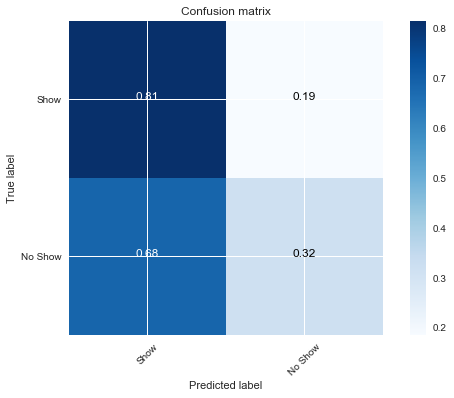

Prediction Analysis

             precision    recall  f1-score   support

          0       0.90      0.82      0.86     24141
          1       0.22      0.35      0.27      3489

avg / total       0.81      0.76      0.78     27630

F1 score achieved 0.5639823534732535
Accuracy score achieved 0.7607672819399204
Normalized confusion matrix
[[ 0.81980862  0.18019138]
 [ 0.64775007  0.35224993]]


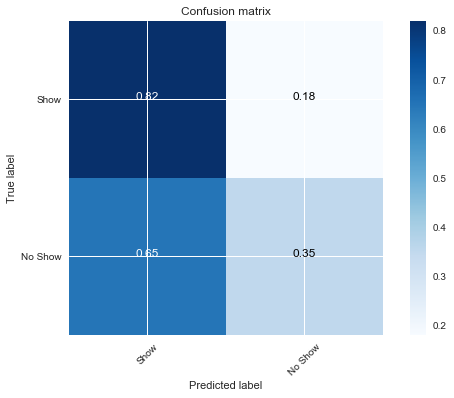

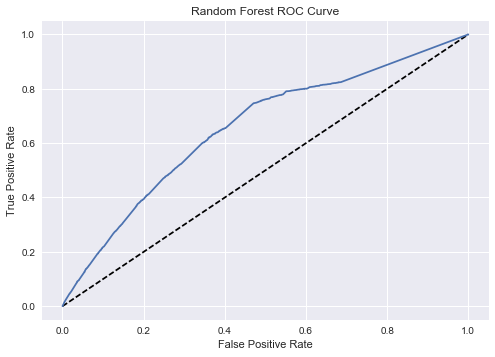

AUC:  0.655946928225
Parameter Analysis



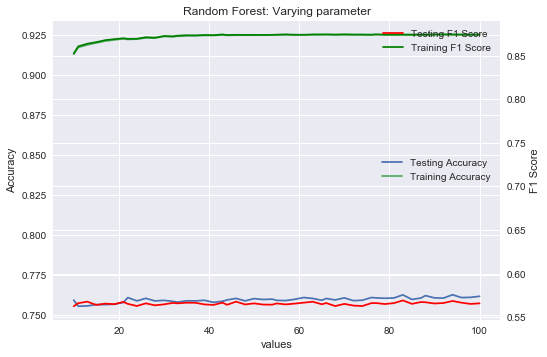

In [39]:
from sklearn.ensemble import RandomForestClassifier
randomForestAnalysis(X_train, X_test, y_train, y_test)

#### Model Number 2

Cross validation Analysis

             precision    recall  f1-score   support

          0       0.89      0.81      0.85     97003
          1       0.19      0.31      0.24     13516

avg / total       0.81      0.75      0.78    110519

F1 score achieved 0.5448209583064698
Accuracay score achieved 0.7526941068956469
Normalized confusion matrix
[[ 0.81375834  0.18624166]
 [ 0.68555786  0.31444214]]


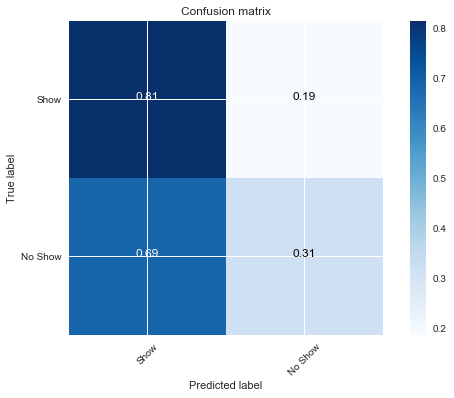

Prediction Analysis

             precision    recall  f1-score   support

          0       0.90      0.82      0.86     24189
          1       0.21      0.34      0.26      3441

avg / total       0.81      0.76      0.78     27630

F1 score achieved 0.5594672833917707
Accuracy score achieved 0.7593195801664857
Normalized confusion matrix
[[ 0.81834718  0.18165282]
 [ 0.65562337  0.34437663]]


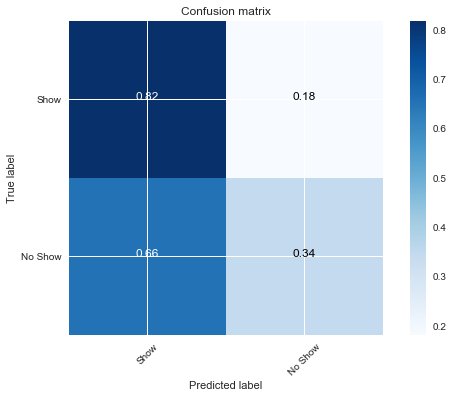

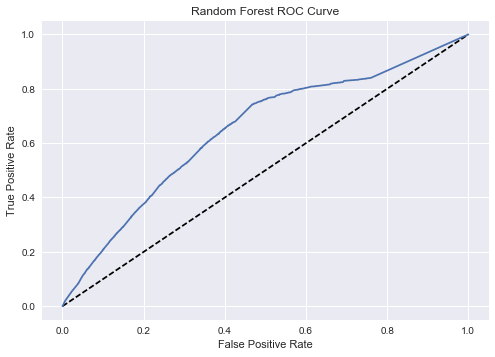

AUC:  0.647047025834
Parameter Analysis



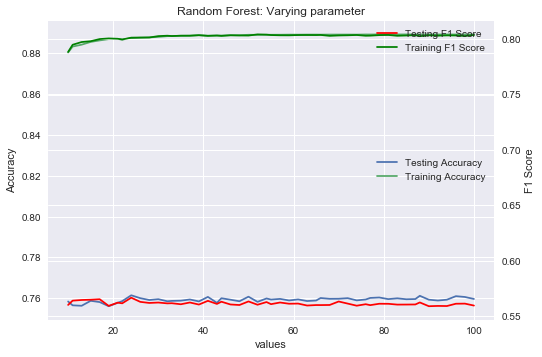

In [41]:
predictors = ['Patient_Age', 'Patient_Gender', 'Patient_Scholarship', 'Patient_Hypertension', 'Patient_Diabetes', 
              'Patient_Alcoholism', 'Patient_Handicap', 'SMS_Received', 'Appointment_Date_Month',
              'Appointment_ElapsedTime', 'Saturday']

X = data[predictors]
y = data.No_Show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 121, stratify= y)
from sklearn.ensemble import RandomForestClassifier
randomForestAnalysis(X_train, X_test, y_train, y_test)

## KNN

In [46]:
def knnModel(p):
    knn = KNeighborsClassifier(n_neighbors= p)
    return knn

def knnAnalysis(X_train, X_test, y_train, y_test):
    print('Cross validation Analysis\n')
    knn = KNeighborsClassifier()
    crossValidation(knn, X, y)
    
    print('Prediction Analysis\n')
    knn = KNeighborsClassifier()
    trainAndPredict(knn, 'KNN', X_train, y_train, X_test, y_test)
    
    print('Parameter Analysis\n')
    n_neighbors = np.linspace(1, 20, num=50,dtype=int)
    modelParameterTuning('KNN', knnModel, n_neighbors, X_train, y_train, X_test, y_test)

### Model Number 1

In [48]:
predictors = ['Patient_Age', 'Patient_Gender', 'Patient_Scholarship', 'Patient_Hypertension', 'Patient_Diabetes', 
              'Patient_Alcoholism', 'Patient_Handicap', 'SMS_Received', 'Appointment_Date_Month',
              'Appointment_ElapsedTime', 'Saturday', 'Ratio_Adjusted', 'First_Time', 'Previous_Appointment']

X = data[predictors]
y = data.No_Show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 121, stratify= y)


Cross validation Analysis

             precision    recall  f1-score   support

          0       0.91      0.81      0.86     99020
          1       0.17      0.33      0.22     11499

avg / total       0.84      0.76      0.79    110519

F1 score achieved 0.5423311556115696
Accuracay score achieved 0.7627828699137705
Normalized confusion matrix
[[ 0.81299737  0.18700263]
 [ 0.66962345  0.33037655]]


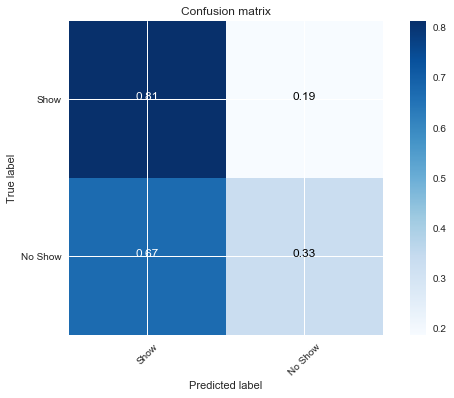

Prediction Analysis

             precision    recall  f1-score   support

          0       0.92      0.82      0.87     24769
          1       0.19      0.37      0.25      2861

avg / total       0.84      0.77      0.80     27630

F1 score achieved 0.5583795761118006
Accuracy score achieved 0.7714078899746653
Normalized confusion matrix
[[ 0.81763495  0.18236505]
 [ 0.62880112  0.37119888]]


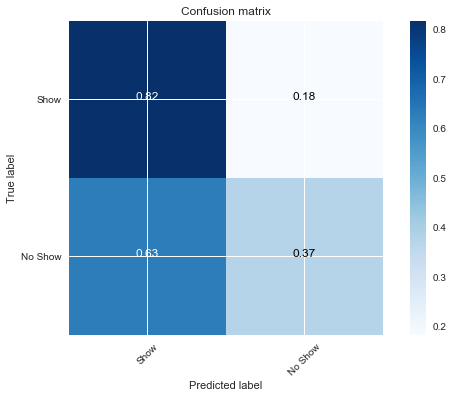

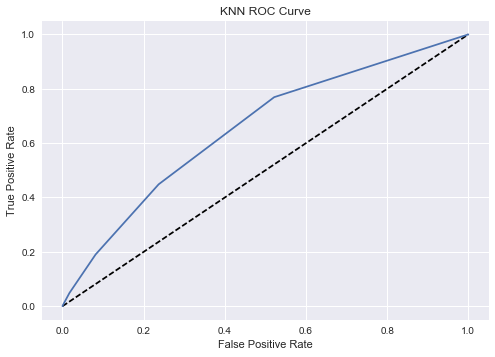

AUC:  0.654199829529
Parameter Analysis



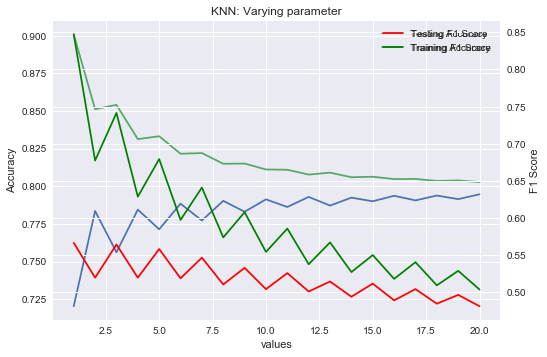

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knnAnalysis(X_train, X_test, y_train, y_test)

### KNN Model Number 2

Cross validation Analysis

             precision    recall  f1-score   support

          0       0.91      0.81      0.86     98703
          1       0.17      0.32      0.22     11816

avg / total       0.83      0.76      0.79    110519

F1 score achieved 0.5388657422423445
Accuracay score achieved 0.7591545345144274
Normalized confusion matrix
[[ 0.81197127  0.18802873]
 [ 0.6820413   0.3179587 ]]


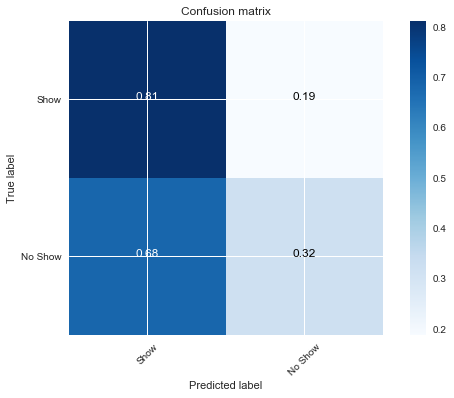

Prediction Analysis

             precision    recall  f1-score   support

          0       0.91      0.81      0.86     24750
          1       0.18      0.34      0.23      2880

avg / total       0.84      0.77      0.80     27630

F1 score achieved 0.5476769197449535
Accuracy score achieved 0.7654361201592472
Normalized confusion matrix
[[ 0.81454545  0.18545455]
 [ 0.65659722  0.34340278]]


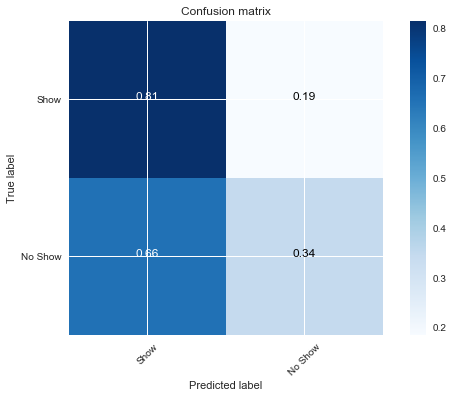

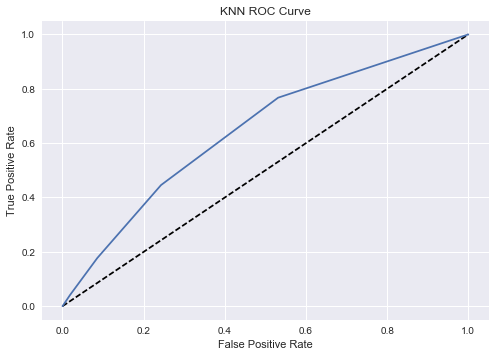

AUC:  0.645714241495
Parameter Analysis



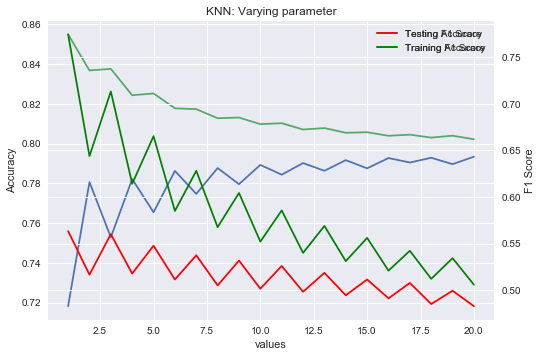

In [51]:
predictors = ['Patient_Age', 'Patient_Gender', 'Patient_Scholarship', 'Patient_Hypertension', 'Patient_Diabetes', 
              'Patient_Alcoholism', 'Patient_Handicap', 'SMS_Received', 'Appointment_Date_Month',
              'Appointment_ElapsedTime', 'Saturday']

X = data[predictors]
y = data.No_Show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 121, stratify= y)
from sklearn.neighbors import KNeighborsClassifier
knnAnalysis(X_train, X_test, y_train, y_test)

Cross validation Analysis

             precision    recall  f1-score   support

          0       0.91      0.81      0.86     98703
          1       0.17      0.32      0.22     11816

avg / total       0.83      0.76      0.79    110519

F1 score achieved 0.5388657422423445
Accuracay score achieved 0.7591545345144274
Normalized confusion matrix
[[ 0.81197127  0.18802873]
 [ 0.6820413   0.3179587 ]]


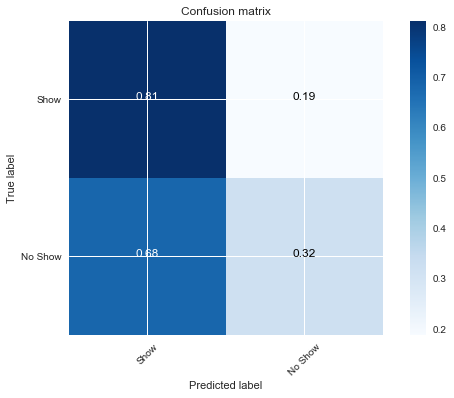

Prediction Analysis

             precision    recall  f1-score   support

          0       0.91      0.81      0.86     24750
          1       0.18      0.34      0.23      2880

avg / total       0.84      0.77      0.80     27630

F1 score achieved 0.5476769197449535
Accuracy score achieved 0.7654361201592472
Normalized confusion matrix
[[ 0.81454545  0.18545455]
 [ 0.65659722  0.34340278]]


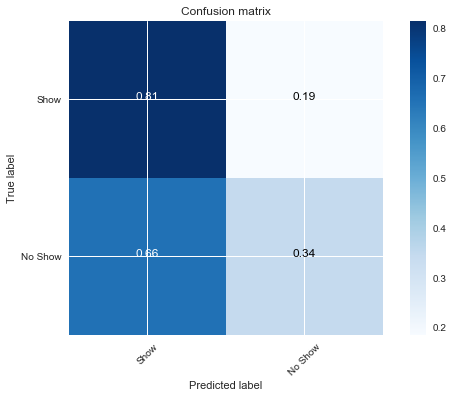

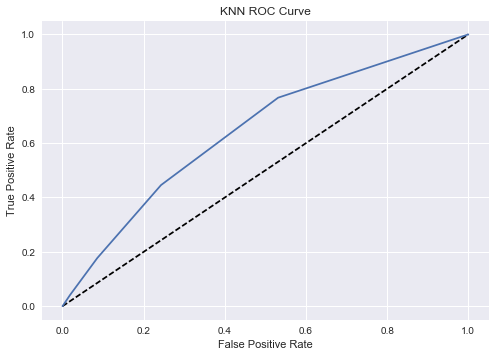

AUC:  0.645714241495
Parameter Analysis



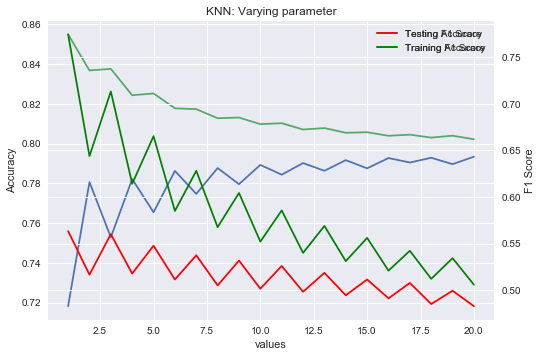

In [52]:
from sklearn.neighbors import KNeighborsClassifier
knnAnalysis(X_train, X_test, y_train, y_test)

## Logistic regression models

In [59]:
def logistRegressionModel(p):
    logreg = LogisticRegression(C= p)
    return logreg

def logisticRegressionAnalysis(X_train, X_test, y_train, y_test):
    print('Cross validation Analysis\n')
    logreg = LogisticRegression()
    crossValidation(logreg, X, y)
    
    print('Prediction Analysis\n')
    logreg = LogisticRegression()
    trainAndPredict(logreg, 'Logistic Regression', X_train, y_train, X_test, y_test)
    
    print('Parameter Analysis\n')
    C_values = np.linspace(0.1, 5.0, num=50)
    modelParameterTuning('Logistic Regression', logistRegressionModel, C_values, X_train, y_train, X_test, y_test)
    

### Model number 1

In [103]:
predictors = [
    'Patient_Age', 
    'Patient_Gender', 
    'Patient_Scholarship', 
    'Patient_Hypertension', 
    'Patient_Diabetes', 
    'Patient_Alcoholism', 
    'Patient_Handicap', 
    'SMS_Received', 
    'Appointment_Date_Month',
    'Appointment_ElapsedTime', 
    'Saturday', 
    'Ratio_Adjusted', 
    'First_Time', 
    'Previous_Appointment',
    'No_Show_per_patient'
             ]
X = data[predictors]
y = data.No_Show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 121, stratify= y)

Cross validation Analysis

             precision    recall  f1-score   support

          0       0.97      0.95      0.96     90000
          1       0.80      0.87      0.83     20519

avg / total       0.94      0.93      0.94    110519

F1 score achieved 0.8951902364865809
Accuracay score achieved 0.9344999502348013
Normalized confusion matrix
[[ 0.9498     0.0502   ]
 [ 0.1326088  0.8673912]]


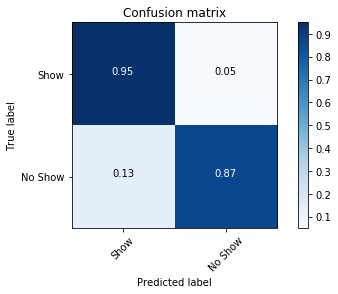

Prediction Analysis

             precision    recall  f1-score   support

          0       0.97      0.95      0.96     22487
          1       0.80      0.87      0.83      5143

avg / total       0.94      0.93      0.94     27630

F1 score achieved 0.8953900975212706
Accuracy score achieved 0.9345638798407528
Normalized confusion matrix
[[ 0.9501045   0.0498955 ]
 [ 0.13338518  0.86661482]]


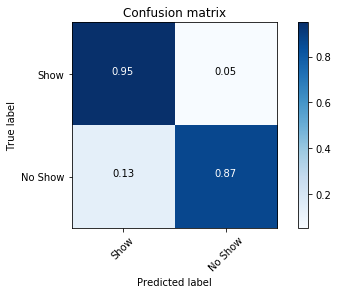

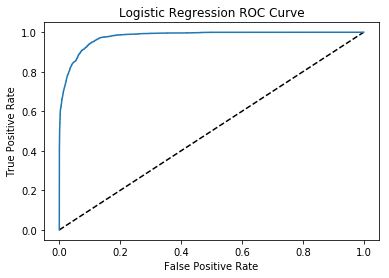

AUC:  0.978057567813
Parameter Analysis



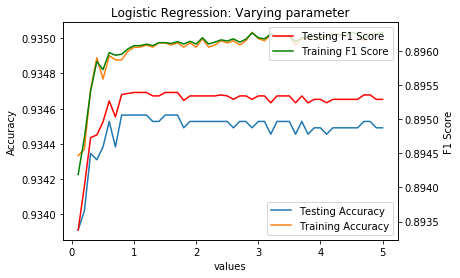

In [104]:
from sklearn.linear_model import LogisticRegression
logisticRegressionAnalysis(X_train, X_test, y_train, y_test)

### Model number 2

Cross validation Analysis

             precision    recall  f1-score   support

          0       0.99      0.80      0.88    109020
          1       0.02      0.30      0.04      1499

avg / total       0.97      0.79      0.87    110519

F1 score achieved 0.46080151690603627
Accuracay score achieved 0.7926600855961419
Normalized confusion matrix
[[ 0.7994313   0.2005687 ]
 [ 0.69979987  0.30020013]]


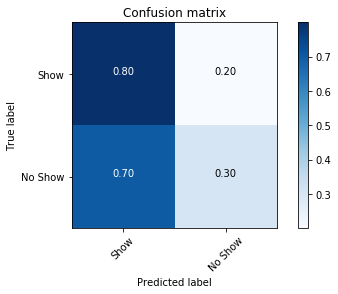

Prediction Analysis

             precision    recall  f1-score   support

          0       0.99      0.80      0.89     27321
          1       0.02      0.38      0.04       309

avg / total       0.98      0.80      0.88     27630

F1 score achieved 0.4624216573202906
Accuracy score achieved 0.7952949692363374
Normalized confusion matrix
[[ 0.80004392  0.19995608]
 [ 0.62459547  0.37540453]]


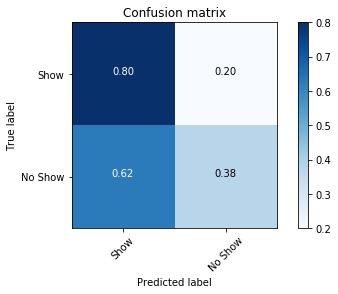

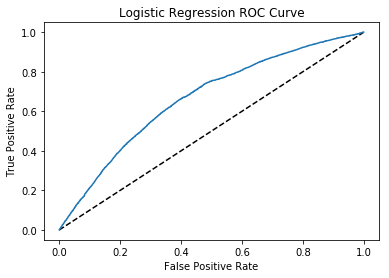

AUC:  0.665677645921
Parameter Analysis



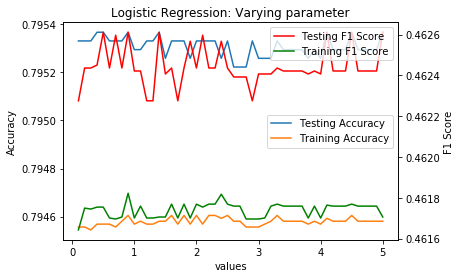

In [105]:
predictors = ['Patient_Age', 'Patient_Gender', 'Patient_Scholarship', 'Patient_Hypertension', 'Patient_Diabetes', 
              'Patient_Alcoholism', 'Patient_Handicap', 'SMS_Received', 'Appointment_Date_Month',
              'Appointment_ElapsedTime', 'Saturday', 'Ratio_Adjusted', 'First_Time', 'Previous_Appointment']

X = data[predictors]
y = data.No_Show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 121, stratify= y)
from sklearn.linear_model import LogisticRegression
logisticRegressionAnalysis(X_train, X_test, y_train, y_test)

### Model number 3


C:\Users\mjm30\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\mjm30\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\mjm30\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Prediction Analysis

             precision    recall  f1-score   support

          0       0.91      0.82      0.86     24532
          1       0.19      0.35      0.25      3098

avg / total       0.83      0.76      0.79     27630

F1 score achieved 0.5541064277893578
Accuracy score achieved 0.7639160332971408
Normalized confusion matrix
[[ 0.81648459  0.18351541]
 [ 0.65235636  0.34764364]]


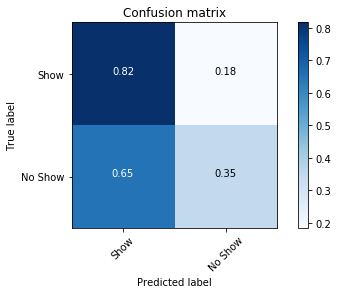

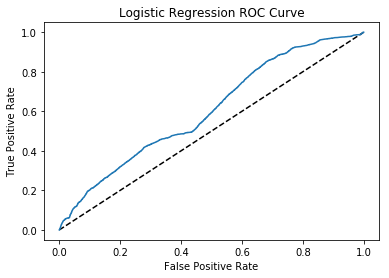

AUC:  0.605234907827
Parameter Analysis



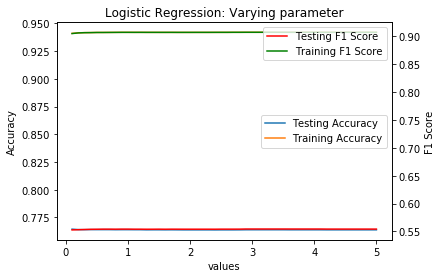

In [106]:
predictors = ['Patient_Age', 'Patient_Gender', 'Patient_Scholarship', 'Patient_Hypertension', 'Patient_Diabetes', 
              'Patient_Alcoholism', 'Patient_Handicap', 'SMS_Received', 'Appointment_Date_Month',
              'Appointment_ElapsedTime', 'Saturday', 'Ratio_Adjusted', 'First_Time', 'Previous_Appointment']

X_train, X_test, y_train, y_test = getAdjustedData(predictors)
from sklearn.linear_model import LogisticRegression


print('Prediction Analysis\n')
logreg = LogisticRegression()
trainAndPredict(logreg, 'Logistic Regression', X_train, y_train, X_test, y_test)
    
print('Parameter Analysis\n')
C_values = np.linspace(0.1, 5.0, num=50)
modelParameterTuning('Logistic Regression', logistRegressionModel, C_values, X_train, y_train, X_test, y_test)

## Neural network models

In [63]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

In [64]:
def toNpArray(X_train, X_test, y_train, y_test):
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test) 

In [109]:
def paramNN(training, y_train, predictions, y_test, a, b):
    treshold = np.linspace(a, b, num=(b-a)*100)
    
    f1_test = np.empty(len(treshold))
    acc_test = np.empty(len(treshold))
    f1_train = np.empty(len(treshold))
    acc_train = np.empty(len(treshold))
    
    for i,j in enumerate(treshold):
        pred = np.apply_along_axis(lambda x: 1 if x > j else 0, axis= 1, arr= predictions)
        f1_test[i] = f1_score(pred, y_test, average="macro")
        acc_test[i] = accuracy_score(pred, y_test)

        tr = np.apply_along_axis(lambda x: 1 if x > j else 0, axis= 1, arr= training)
        f1_train[i] = f1_score(tr, y_train, average="macro")
        acc_train[i] = accuracy_score(tr, y_train)
    parameterTuning('Neural Network', acc_train, f1_train, acc_test, f1_test, treshold)

In [110]:
def NN(X_train, X_test, y_train, y_test, a= 0.0, b= 1.0):
    
    X_train, X_test, y_train, y_test = toNpArray(X_train, X_test, y_train, y_test)
    
    n_cols = X_train.shape[1]
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape = (n_cols,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(32, activation='softmax'))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer= 'adam', loss= 'mean_squared_error')

    model.fit(X_train, y_train, verbose=False)

    ##Calculate performance on training
    training = model.predict(X_train)
    # Calculate predictions: predictions
    predictions = model.predict(X_test)
    
    paramNN(training, y_train,predictions, y_test, a, b)
    return predictions

In [69]:
def categorizeNN(threshold, predictions, y_test):
    pred = np.apply_along_axis(lambda x: 1 if x > threshold else 0, axis= 1, arr= predictions)
    report = classification_report(pred, y_test)
    conf_matrix = confusion_matrix(pred, y_test)
    print(report)
    print('F1 score achieved {}'.format( f1_score(pred, y_test, average="macro")))
    print('Accuracy score achieved {}'.format( accuracy_score(pred, y_test)))
    plot_confusion_matrix(conf_matrix, ['Show', 'No Show'], normalize= True)

### Model number 1

C:\Users\mjm30\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
C:\Users\mjm30\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


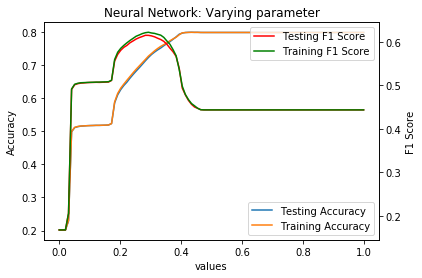

In [112]:
predictors = ['Patient_Age', 'Patient_Gender', 'Patient_Scholarship', 'Patient_Hypertension', 'Patient_Diabetes', 
              'Patient_Alcoholism', 'Patient_Handicap', 'SMS_Received', 'Appointment_Date_Month',
              'Appointment_ElapsedTime', 'Saturday', 'Ratio_Adjusted', 'First_Time', 'Previous_Appointment']
X = data[predictors]
y = data.No_Show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 121, stratify= y)
predictions = NN(X_train, X_test, y_train, y_test)

C:\Users\mjm30\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


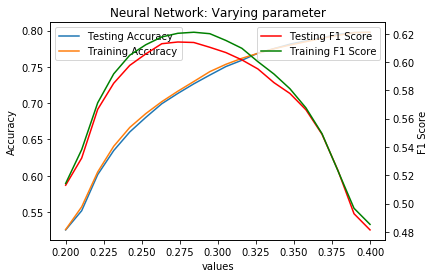

In [114]:
predictions = NN(X_train, X_test, y_train, y_test, 0.2, 0.4)

             precision    recall  f1-score   support

          0       0.80      0.85      0.82     20657
          1       0.45      0.36      0.40      6973

avg / total       0.71      0.73      0.72     27630

F1 score achieved 0.6140557668410735
Accuracy score achieved 0.7289902280130293
Normalized confusion matrix
[[ 0.85249552  0.14750448]
 [ 0.63688513  0.36311487]]


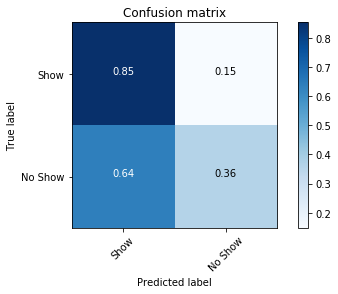

In [113]:
categorizeNN(0.3, predictions, y_test)

### Model number 2


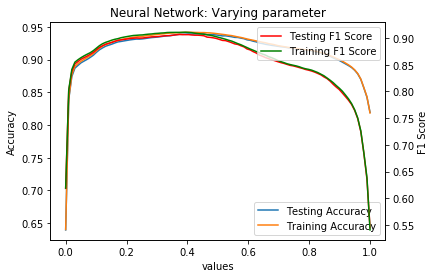

In [71]:
predictors = ['Patient_Age', 'Patient_Gender', 'Patient_Scholarship', 'Patient_Hypertension', 'Patient_Diabetes', 
              'Patient_Alcoholism', 'Patient_Handicap', 'SMS_Received', 'Appointment_Date_Month',
              'Appointment_ElapsedTime', 'Saturday', 'Ratio_Adjusted', 'First_Time', 'Previous_Appointment', 'No_Show_per_patient']
X = data[predictors]
y = data.No_Show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 121, stratify= y)
predictions = NN(X_train, X_test, y_train, y_test)

             precision    recall  f1-score   support

          0       0.96      0.97      0.96     21805
          1       0.87      0.83      0.85      5825

avg / total       0.94      0.94      0.94     27630

F1 score achieved 0.9065250983704713
Accuracy score achieved 0.9387622149837134
Normalized confusion matrix
[[ 0.96684247  0.03315753]
 [ 0.16635193  0.83364807]]


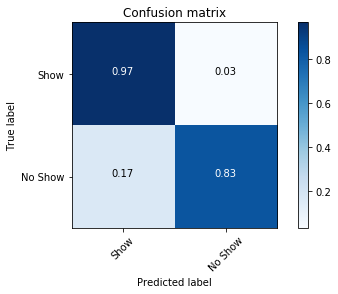

In [72]:
categorizeNN(0.38, predictions, y_test)

### Model number 3

C:\Users\mjm30\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\mjm30\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\mjm30\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

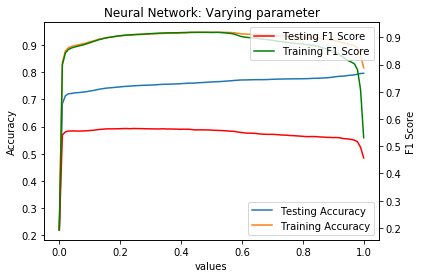

In [92]:
predictors = ['Patient_Age', 'Patient_Gender', 'Patient_Scholarship', 'Patient_Hypertension', 'Patient_Diabetes', 
              'Patient_Alcoholism', 'Patient_Handicap', 'SMS_Received', 'Appointment_Date_Month',
              'Appointment_ElapsedTime', 'Saturday', 'Ratio_Adjusted', 'First_Time', 'Previous_Appointment']

X_train, X_test, y_train, y_test = getAdjustedData(predictors)
predictions = NN(X_train, X_test, y_train, y_test)

             precision    recall  f1-score   support

          0       0.84      0.82      0.83     22563
          1       0.27      0.30      0.28      5067

avg / total       0.73      0.72      0.73     27630

F1 score achieved 0.5561381713134109
Accuracy score achieved 0.7238508867173362
Normalized confusion matrix
[[ 0.81957187  0.18042813]
 [ 0.702388    0.297612  ]]


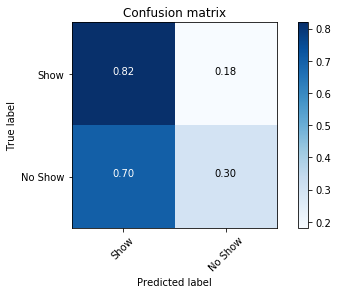

In [93]:
categorizeNN(0.05, predictions, y_test)

## Bayes net models

### Model number 1

             precision    recall  f1-score   support

          0       0.95      0.81      0.87     26076
          1       0.09      0.33      0.15      1554

avg / total       0.90      0.78      0.83     27630

feature importances
F1 score achieved 0.5095993374299507
Accuracy score achieved 0.7794788273615635
Normalized confusion matrix
[[ 0.80599018  0.19400982]
 [ 0.66537967  0.33462033]]


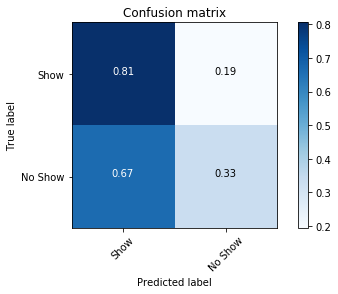

In [15]:
from sklearn.naive_bayes import GaussianNB

predictors = [
    'Patient_Age', 
    'Patient_Gender', 
    'Patient_Scholarship', 
    'Patient_Hypertension', 
    'Patient_Diabetes', 
    'Patient_Alcoholism', 
    'Patient_Handicap', 
    'SMS_Received', 
    'Appointment_Date_Month',
    'Appointment_ElapsedTime', 
    'Saturday'
             ]
X = data[predictors]
y = data.No_Show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 121, stratify= y)	

model = GaussianNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
report = classification_report(predictions, y_test)
conf_matrix = confusion_matrix(predictions, y_test)
print(report)
print("feature importances")
print('F1 score achieved {}'.format( f1_score(predictions, y_test, average="macro")))
print('Accuracy score achieved {}'.format( accuracy_score(predictions, y_test)))
plot_confusion_matrix(conf_matrix, ['Show', 'No Show'], normalize= True)	

## Ada Boost Classifier Models

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


def adaBoostModel(p):
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=p)
    return ada

def adaBoostAnalysis(X_train, X_test, y_train, y_test):
    print('Cross validation Analysis\n')
    ada = AdaBoostClassifier()
    crossValidation(ada, X, y)
    
    print('Prediction Analysis\n')
    ada = AdaBoostClassifier()
    trainAndPredict(ada, 'AdaBoost', X_train, y_train, X_test, y_test)
    
    print('Parameter Analysis\n')
    n_estimators = np.linspace(40, 80, num=20, dtype=int)
    modelParameterTuning('AdaBoost', adaBoostModel, n_estimators, X_train, y_train, X_test, y_test)

### Model number 1

Cross validation Analysis

             precision    recall  f1-score   support

          0       1.00      0.80      0.89    110216
          1       0.01      0.43      0.01       303

avg / total       1.00      0.80      0.88    110519

F1 score achieved 0.44935523951167955
Accuracay score achieved 0.7976727983423665
Normalized confusion matrix
[[ 0.79869529  0.20130471]
 [ 0.57425743  0.42574257]]


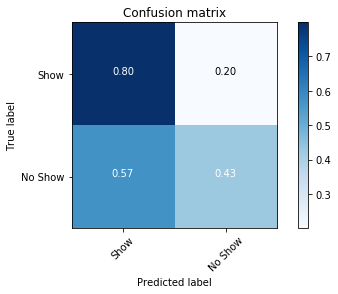

Prediction Analysis

             precision    recall  f1-score   support

          0       1.00      0.80      0.89     27544
          1       0.01      0.44      0.01        86

avg / total       0.99      0.80      0.88     27630

F1 score achieved 0.45036144936385425
Accuracy score achieved 0.7977198697068404
Normalized confusion matrix
[[ 0.79883096  0.20116904]
 [ 0.55813953  0.44186047]]


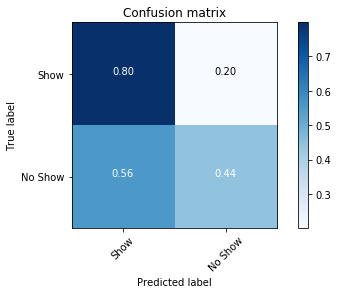

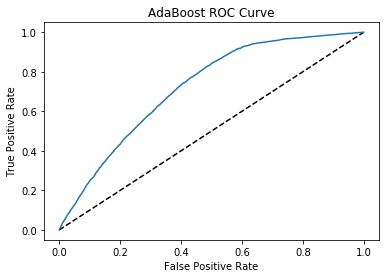

AUC:  0.720683054727
Parameter Analysis



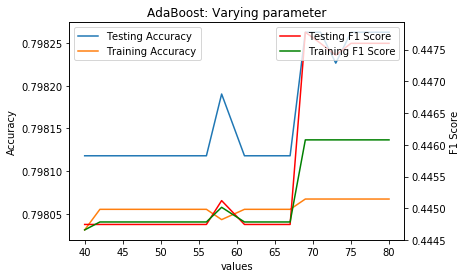

In [17]:
predictors = [
    'Patient_Age', 
    'Patient_Gender', 
    'Patient_Scholarship', 
    'Patient_Hypertension', 
    'Patient_Diabetes', 
    'Patient_Alcoholism', 
    'Patient_Handicap', 
    'SMS_Received', 
    'Appointment_Date_Month',
    'Appointment_ElapsedTime', 
    'Saturday'
             ]
X = data[predictors]
y = data.No_Show
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 121, stratify= y)		
adaBoostAnalysis(X_train, X_test, y_train, y_test)

## SVM
### Model number 1